<a href="https://colab.research.google.com/github/Ark1645/Deep-Learning/blob/main/Cifar100_spatial_%26_channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=398e4a301aca1846087c362cebc3f199faa8611aa459e98b283da0cccadc98e1
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [19]:
  import tensorflow as tf
  from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
  from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
  import tensorflow as tf
  from tensorflow.keras.datasets import cifar100
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input,MaxPooling2D
  from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
  from tensorflow.keras.models import Model
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.losses import CategoricalCrossentropy
  import tensorflow as tf
  import tensorflow_datasets as tfds
  import numpy as np
  import matplotlib.pyplot as plt
  from visualize import plotImages, plotHistory, explainGradCam
  from tensorflow.keras.datasets import cifar100
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
  from tensorflow.keras.losses import categorical_crossentropy
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.utils import to_categorical
  from tensorflow.keras.callbacks import Callback, EarlyStopping
  from keras.preprocessing.image import ImageDataGenerator
  import matplotlib.pyplot as plt
  import numpy as np
  from tensorflow.keras.datasets import cifar100
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
  from tensorflow.keras.losses import categorical_crossentropy
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.callbacks import ReduceLROnPlateau
  from tensorflow.keras.utils import to_categorical
  from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard
  from keras.preprocessing.image import ImageDataGenerator
  from tensorflow.keras import regularizers
  import matplotlib.pyplot as plt
  import numpy as np
  import larq as lq

In [20]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [21]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

In [23]:
ds_info

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar100/3.0.2',
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disable_shuf

In [24]:
ds_info.features['label'].names

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

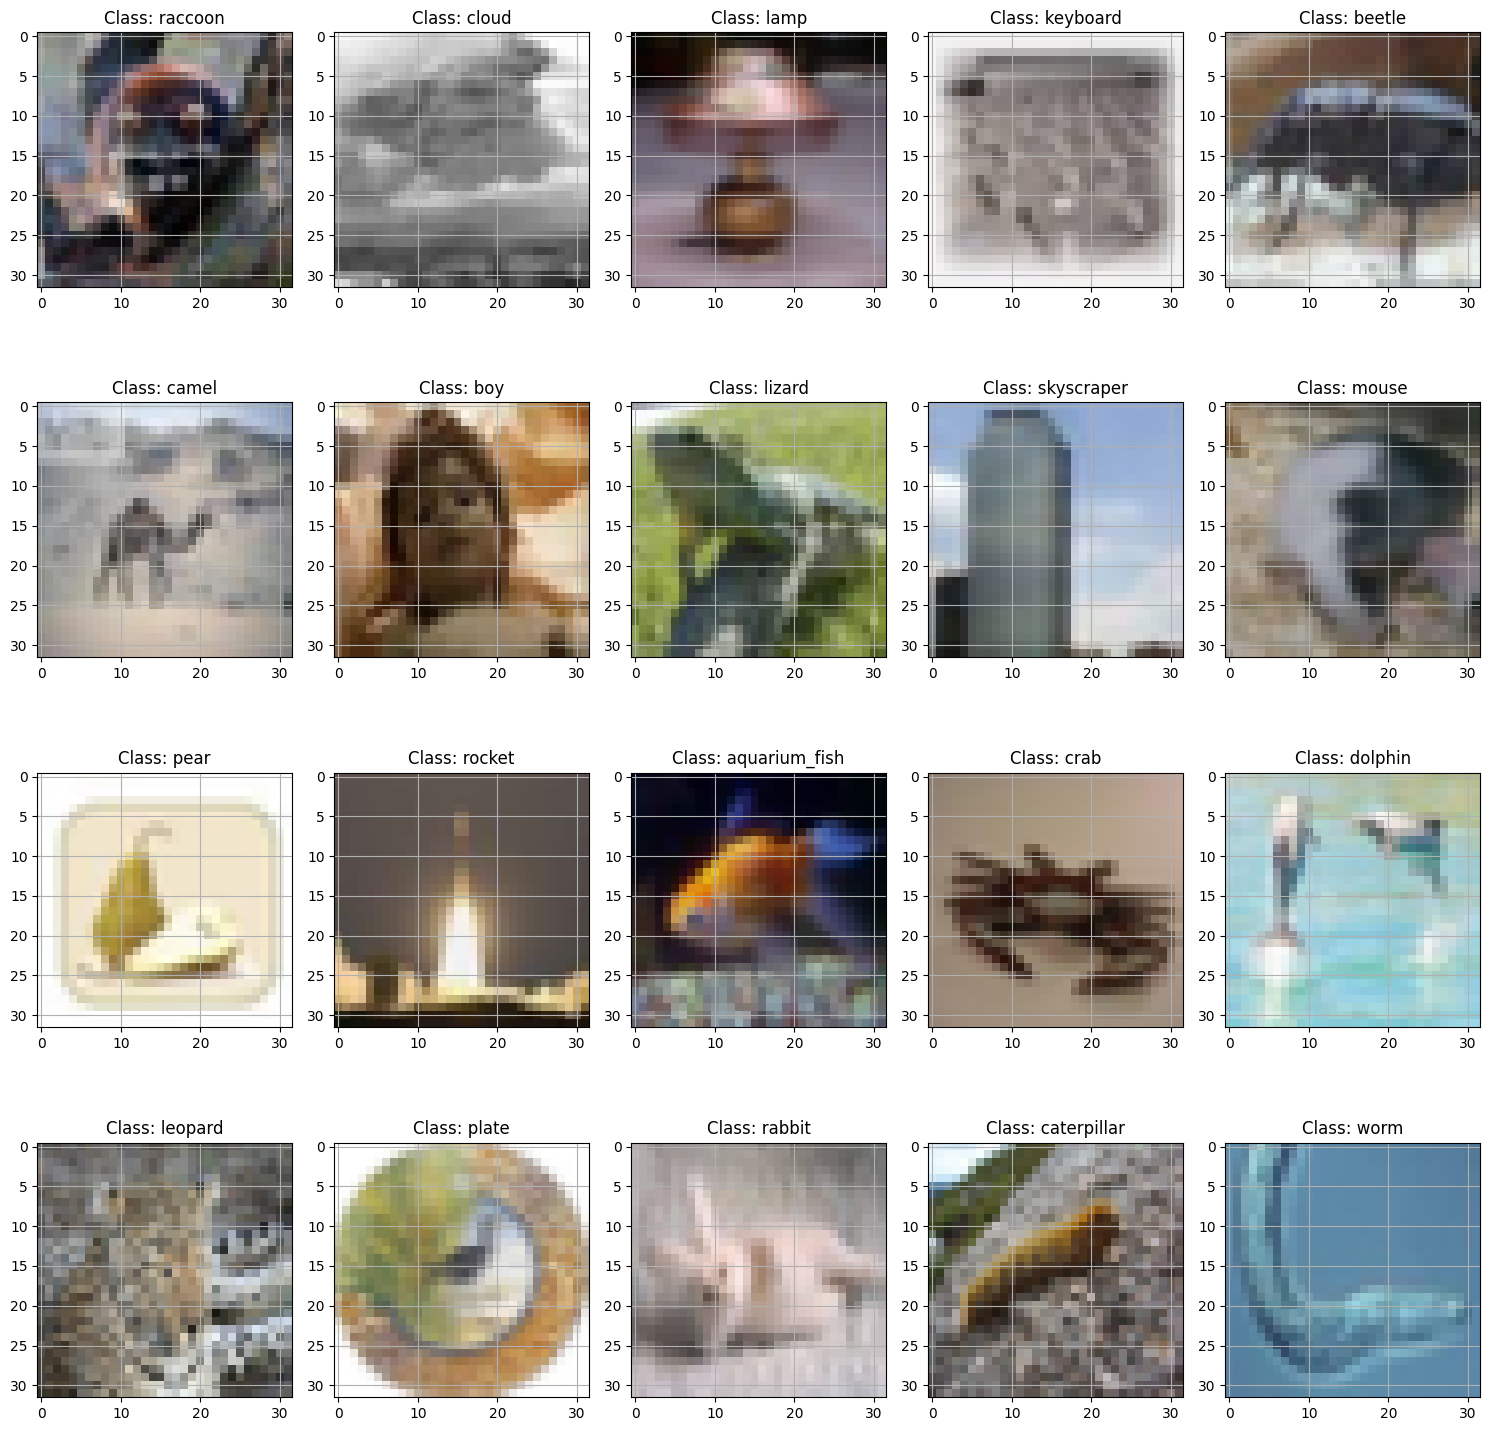

In [25]:
for data in ds_train.batch(20):
    plotImages(data, 20, ds_info.features['label'].names)
    break

In [26]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [27]:
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [28]:
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
pip install larq

NETWORK WITHOUT ATTENTION

In [30]:
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

simple_bnn_no_attention = tf.keras.models.Sequential([   #Model name

    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(100, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])


In [31]:
simple_bnn_no_attention.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_conv2d (QuantConv2D)  (None, 30, 30, 128)       3456      
                                                                 
 batch_normalization (Batch  (None, 30, 30, 128)       384       
 Normalization)                                                  
                                                                 
 quant_conv2d_1 (QuantConv2  (None, 30, 30, 128)       147456    
 D)                                                              
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 15, 15, 128)       384       
 chNormalization)                                       

In [32]:
simple_bnn_no_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [34]:
history = simple_bnn_no_attention.fit(ds_train, epochs=40,validation_data=ds_test)

Epoch 1/40
1563/1563 [==============================] - 44s 28ms/step - loss: 3.0502 - accuracy: 0.2964 - val_loss: 3.1401 - val_accuracy: 0.2715
Epoch 2/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.8051 - accuracy: 0.3556 - val_loss: 3.0171 - val_accuracy: 0.3010
Epoch 3/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.6084 - accuracy: 0.4056 - val_loss: 2.8869 - val_accuracy: 0.3250
Epoch 4/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.4549 - accuracy: 0.4430 - val_loss: 2.7307 - val_accuracy: 0.3617
Epoch 5/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.3343 - accuracy: 0.4746 - val_loss: 2.6401 - val_accuracy: 0.3917
Epoch 6/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.2229 - accuracy: 0.5091 - val_loss: 2.7575 - val_accuracy: 0.3698
Epoch 7/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.1235 - accuracy: 0.5406 - val_loss: 2.6475 -

NETWORK WITH ATTENTION

In [35]:
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

simple_bnn_with_attention = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    ChannelAttention(128, 8),
    SpatialAttention(7),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    ChannelAttention(256, 8),
    SpatialAttention(7),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    ChannelAttention(256, 8),
    SpatialAttention(7),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    ChannelAttention(512, 8),
    SpatialAttention(7),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    ChannelAttention(512, 8),
    SpatialAttention(7),

    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(100, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])

In [36]:
simple_bnn_with_attention.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_conv2d_6 (QuantConv2  (None, 30, 30, 128)       3456      
 D)                                                              
                                                                 
 batch_normalization_9 (Bat  (None, 30, 30, 128)       384       
 chNormalization)                                                
                                                                 
 quant_conv2d_7 (QuantConv2  (None, 30, 30, 128)       147456    
 D)                                                              
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 128)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Ba  (None, 15, 15, 128)      

In [37]:
simple_bnn_with_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [38]:
history = simple_bnn_with_attention.fit(ds_train, epochs=40,validation_data=ds_test)

Epoch 1/40
1563/1563 [==============================] - 49s 29ms/step - loss: 3.8727 - accuracy: 0.1228 - val_loss: 3.7134 - val_accuracy: 0.1461
Epoch 2/40
1563/1563 [==============================] - 44s 28ms/step - loss: 3.3268 - accuracy: 0.2307 - val_loss: 3.3199 - val_accuracy: 0.2338
Epoch 3/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.9982 - accuracy: 0.3094 - val_loss: 3.1382 - val_accuracy: 0.2800
Epoch 4/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.7629 - accuracy: 0.3650 - val_loss: 3.0327 - val_accuracy: 0.2967
Epoch 5/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.5759 - accuracy: 0.4104 - val_loss: 2.9657 - val_accuracy: 0.3096
Epoch 6/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.4235 - accuracy: 0.4508 - val_loss: 2.7751 - val_accuracy: 0.3525
Epoch 7/40
1563/1563 [==============================] - 44s 28ms/step - loss: 2.3086 - accuracy: 0.4845 - val_loss: 2.6983 -

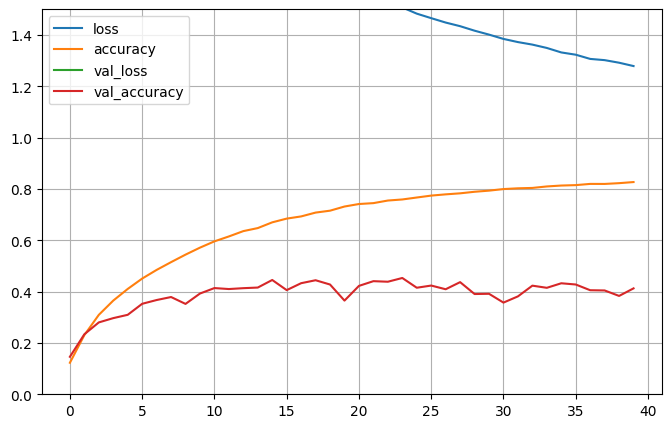

In [39]:
plotHistory(history)

In [40]:
print(f"Test accuracy: {simple_bnn_with_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 3s 9ms/step - loss: 2.6942 - accuracy: 0.4126
Test accuracy: 0.41260001063346863


VISUALIZE THE NETWORKS

In [41]:
pip install tf-explain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00


In [42]:
from tf_explain.core.grad_cam import GradCAM

In [43]:
explainer = GradCAM()

In [44]:
for images, labels in tfds.as_numpy(ds_test.take(1)):
    X_test = images
    y_test = labels

In [45]:
print(X_test.shape, y_test.shape)

(32, 32, 32, 3) (32,)


NETWORK WITHOUT AND WITH ATTENTION

1/1 [==============================] - 0s 17ms/step


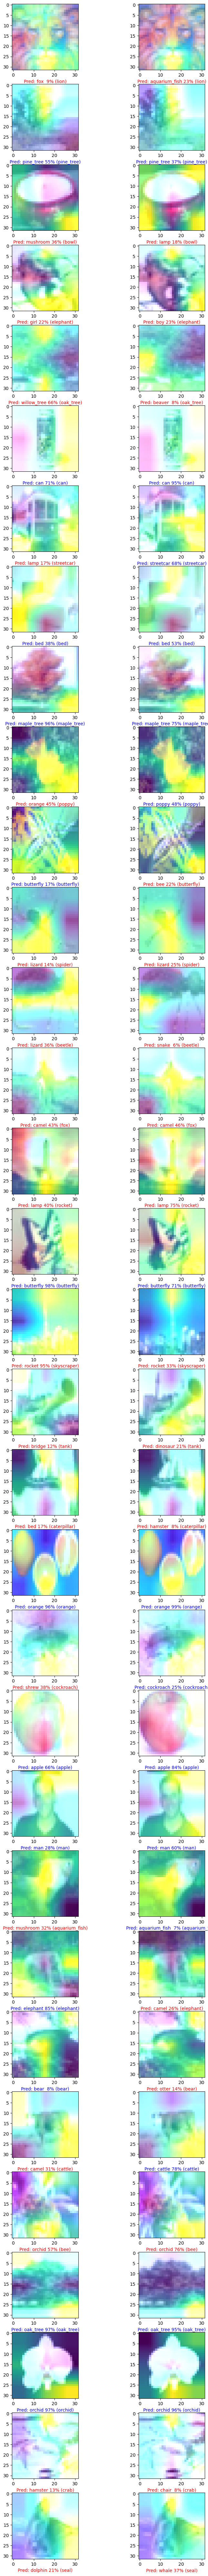

In [47]:
fig, axes = plt.subplots(32, 2, figsize=(8,80))
fig.tight_layout()
index = 0
for img, label in zip(X_test, y_test):
    explainGradCam(explainer, axes[index], img,
               label,
               simple_bnn_no_attention,
               simple_bnn_no_attention.predict(img[None]),
               simple_bnn_with_attention,
               simple_bnn_with_attention.predict(img[None]),
               class_names=ds_info.features['label'].names)
    index += 1